In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dirname=r'../input/cattle-breeds-dataset/Cattle Breeds'

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1208 files belonging to 5 classes.
Using 967 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
   dirname,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1208 files belonging to 5 classes.
Using 241 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Ayrshire cattle', 'Brown Swiss cattle', 'Holstein Friesian cattle', 'Jersey cattle', 'Red Dane cattle']


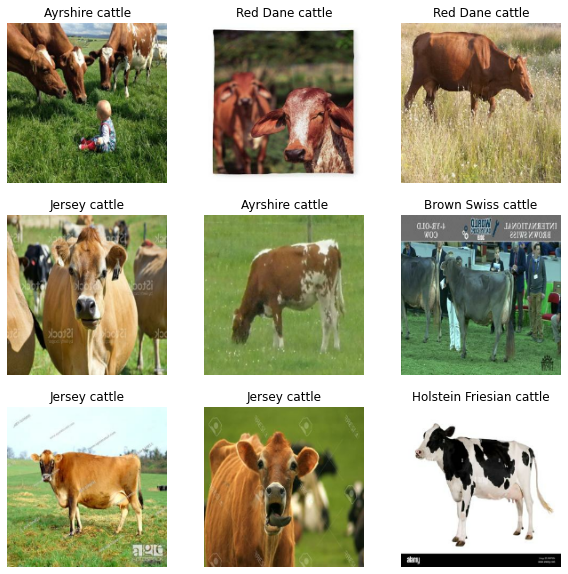

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
31/31 [==============================] - 10s 278ms/step - loss: 1.6049 - accuracy: 0.2978 - val_loss: 1.4093 - val_accuracy: 0.3693
Epoch 2/10
31/31 [==============================] - 7s 235ms/step - loss: 1.2779 - accuracy: 0.4581 - val_loss: 1.2264 - val_accuracy: 0.5062
Epoch 3/10
31/31 [==============================] - 7s 232ms/step - loss: 1.0586 - accuracy: 0.5946 - val_loss: 1.1205 - val_accuracy: 0.5394
Epoch 4/10
31/31 [==============================] - 7s 232ms/step - loss: 0.8645 - accuracy: 0.6815 - val_loss: 1.1238 - val_accuracy: 0.5726
Epoch 5/10
31/31 [==============================] - 8s 257ms/step - loss: 0.6389 - accuracy: 0.7932 - val_loss: 1.1294 - val_accuracy: 0.6100
Epoch 6/10
31/31 [==============================] - 7s 231ms/step - loss: 0.4796 - accuracy: 0.8563 - val_loss: 1.2197 - val_accuracy: 0.5975
Epoch 7/10
31/31 [==============================] - 7s 230ms/step - loss: 0.2726 - accuracy: 0.9224 - val_loss: 1.2730 - val_accuracy: 0.6058
Epoch

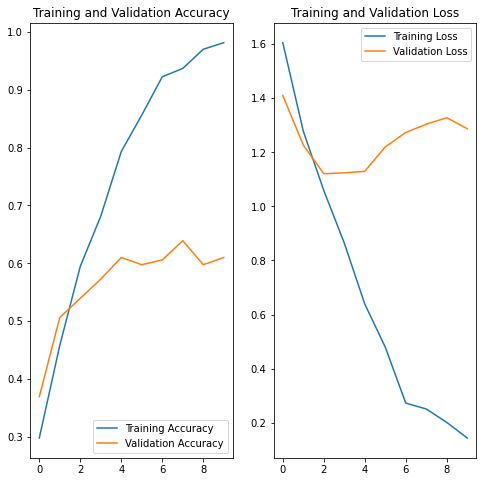

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

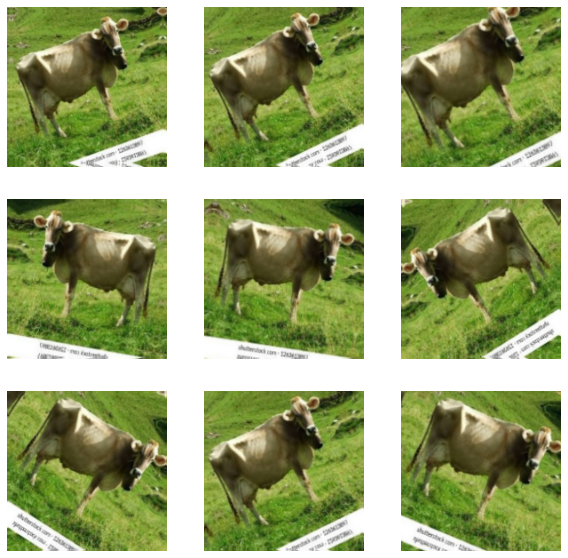

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
31/31 [==============================] - 12s 342ms/step - loss: 1.7037 - accuracy: 0.2596 - val_loss: 1.4548 - val_accuracy: 0.4108
Epoch 2/15
31/31 [==============================] - 10s 312ms/step - loss: 1.3661 - accuracy: 0.4095 - val_loss: 1.3140 - val_accuracy: 0.4357
Epoch 3/15
31/31 [==============================] - 10s 307ms/step - loss: 1.2295 - accuracy: 0.5274 - val_loss: 1.2270 - val_accuracy: 0.5145
Epoch 4/15
31/31 [==============================] - 10s 327ms/step - loss: 1.1086 - accuracy: 0.5553 - val_loss: 1.0360 - val_accuracy: 0.6141
Epoch 5/15
31/31 [==============================] - 10s 308ms/step - loss: 1.0542 - accuracy: 0.5977 - val_loss: 1.0543 - val_accuracy: 0.5726
Epoch 6/15
31/31 [==============================] - 10s 309ms/step - loss: 0.9979 - accuracy: 0.6319 - val_loss: 1.1146 - val_accuracy: 0.5892
Epoch 7/15
31/31 [==============================] - 10s 310ms/step - loss: 0.9811 - accuracy: 0.6432 - val_loss: 1.0551 - val_accuracy: 0.5934

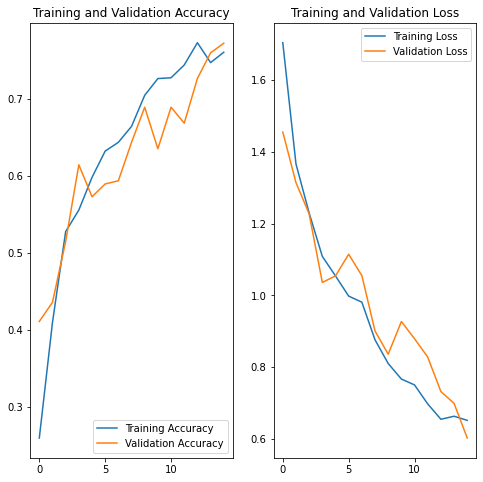

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to Holstein Friesian cattle with a 95.57 percent confidence.


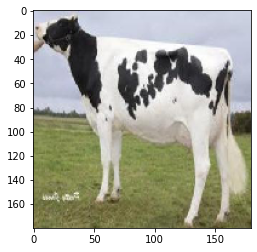

In [22]:
img=tf.keras.utils.load_img("/kaggle/input/cattle-breeds-dataset/Cattle Breeds/Holstein Friesian cattle/HolsteinFriesiancattle61_c.jpg",target_size=(180,180))
plt.imshow(img)
img_array=tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array,0)
pred=model.predict(img_array)
score=tf.nn.softmax(pred[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [23]:
model.save('cattle.h5')